In [15]:
import numpy as np
import h5py
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from lr_utils import load_dataset
import cv2
from dnn_utils import *
np.random.seed(1)

In [3]:
TrainSet_X,TrainSet_Y,TestSet_X,TestSet_Y,classes = load_dataset()
#209 train example
#50 test example
# 0 > non cat
# 1 > cat

mTrain = TrainSet_X.shape[0]
mTest = TestSet_X.shape[0]
px = TrainSet_X.shape[1]

#Flatting the images
TrainSet_X_Flatten = TrainSet_X.reshape(mTrain, -1).T
TestSet_X_Flatten = TestSet_X.reshape(mTest, -1).T

#normalizing
normalTrainX = TrainSet_X_Flatten/255
normalTestX = TestSet_X_Flatten / 255

In [4]:
def initialize_parameters_deep(layer_dims):
    np.random.seed(1)
    parameters = {}
    L = len(layers_dims) - 1 
     
    for l in range(1, L + 1):
        parameters['W' + str(l)] = np.random.randn(layers_dims[l],layers_dims[l-1]) * np.sqrt(2/layers_dims[l-1])
        parameters['b' + str(l)] = np.zeros((layers_dims[l],1))
        
    return parameters

In [5]:
def linear_forward(A, W, b):
    Z = np.dot(W, A) + b
    cache = (A, W, b)
    return Z, cache
def linear_activation_forward(A_prev, W, b, activation):
    if activation == "sigmoid":
        Z, linear_cache = linear_forward(A_prev, W, b)
        A, activation_cache = sigmoid(Z)
    
    elif activation == "relu":
        Z, linear_cache = linear_forward(A_prev, W, b)
        A, activation_cache = relu(Z)
    
    cache = (linear_cache, activation_cache)

    return A, cache
def L_model_forward(X, parameters):
  
    caches = []
    A = X
    L = len(parameters) // 2                  
    
    for l in range(1, L):
        A_prev = A 
        A, cache = linear_activation_forward(
            A_prev, 
            parameters['W' + str(l)], 
            parameters['b' + str(l)], 
            'relu')
        caches.append(cache)
    
    AL, cache = linear_activation_forward(
        A, 
        parameters['W' + str(L)], 
        parameters['b' + str(L)], 
        'sigmoid')
    caches.append(cache)
    
            
    return AL, caches

In [6]:
def compute_cost(AL, Y):
    m = Y.shape[1]

    cost = - (np.dot(Y, np.log(AL).T) + np.dot((1 - Y), np.log(1 - AL).T)) / m
    
    cost = np.squeeze(cost)      
    return cost

In [7]:
def compute_cost_with_regularization(AL, Y, parameters, lambd):
    m = Y.shape[1]
    L = len(parameters) // 2                  
    for l in range(1, L+1):
         weight_sum = np.sum(np.square(parameters['W' + str(l)]))    
    cross_entropy_cost = compute_cost(AL, Y) 
    
    L2_regularization_cost = lambd/(2*m) *np.sum(weight_sum)
    
    cost = cross_entropy_cost + L2_regularization_cost
    
    return cost

In [8]:
def linear_backward(dZ, cache):
    A_prev, W, b = cache
    m = A_prev.shape[1]

    lambd = 0.7
    dW = np.dot(dZ, A_prev.T) / m + (lambd/m * W)
    db = np.sum(dZ, axis=1, keepdims=True) / m
    dA_prev = np.dot(W.T, dZ)

    return dA_prev, dW, db

def linear_activation_backward(dA, cache, activation):
   
    linear_cache, activation_cache = cache
    
    if activation == "relu":
        dZ = relu_backward(dA, activation_cache)
        dA_prev, dW, db = linear_backward(dZ, linear_cache)
        
    elif activation == "sigmoid":
        dZ = sigmoid_backward(dA, activation_cache)
        dA_prev, dW, db = linear_backward(dZ, linear_cache)
    
    return dA_prev, dW, db

def L_model_backward(AL, Y, caches):
   
    grads = {}
    L = len(caches) 
    m = AL.shape[1]
    Y = Y.reshape(AL.shape) 
    
    dAL = -(Y/AL - (1-Y)/(1-AL))
    current_cache = caches[L-1]
    dAl, dWl, dbl = linear_activation_backward(dAL, current_cache, 'sigmoid')
    grads["dA" + str(L)] = dAl
    grads["dW" + str(L)] = dWl
    grads["db" + str(L)] = dbl
    
    for l in reversed(range(L-1)):
        current_cache = caches[l]
        dAl, dWl, dbl = linear_activation_backward(dAl, current_cache, 'relu')
        grads["dA" + str(l + 1)] = dAl
        grads["dW" + str(l + 1)] = dWl
        grads["db" + str(l + 1)] = dbl

    return grads

In [9]:
def update_parameters(parameters, grads, learning_rate):
    L = len(parameters) // 2 # number of layers in the neural network

    for l in range(L):
        parameters["W" + str(l+1)] -= learning_rate * grads['dW' + str(l+1)]
        parameters["b" + str(l+1)] -= learning_rate * grads['db' + str(l+1)]
        
    return parameters

In [10]:
def L_layer_model(X, Y, layers_dims, learning_rate = 0.007, num_iterations = 3000, print_cost=False):#lr was 0.009
    np.random.seed(1)
    costs = []                         
    lambd = 0.7
    parameters = initialize_parameters_deep(layers_dims)
    
    for i in range(0, num_iterations):

        AL, caches = L_model_forward(X, parameters)
        cost = compute_cost_with_regularization(AL, Y,parameters,lambd)
        grads = L_model_backward(AL, Y, caches)
        parameters = update_parameters(parameters, grads, learning_rate)
        if print_cost and i % 500 == 0:
            print ("Cost after iteration %i: %f" %(i, cost))
        if i % 10 == 0:
            costs.append(cost)    
            
    plt.plot(np.squeeze(costs))
    plt.ylabel('cost')
    plt.xlabel('iterations (per tens)')
    plt.title("Learning rate =" + str(learning_rate))
    plt.show()
    
    return parameters

Cost after iteration 0: 0.731889
Cost after iteration 500: 0.202725
Cost after iteration 1000: 0.043971
Cost after iteration 1500: 0.021501
Cost after iteration 2000: 0.015452


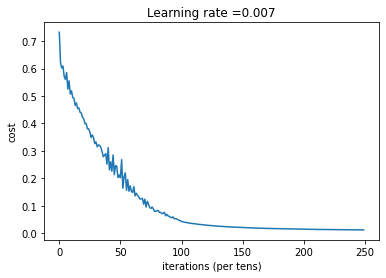

In [11]:
layers_dims = [12288, 20,5, 1] #  5-layer model
parameters = L_layer_model(normalTrainX,TrainSet_Y,layers_dims,num_iterations=2500, print_cost=True)

In [11]:
predict(normalTrainX,TrainSet_Y,parameters)

Accuracy: 0.9999999999999998


array([[0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 1., 1., 0.,
        0., 0., 0., 1., 0., 0., 0., 0., 1., 1., 0., 1., 0., 1., 0., 0.,
        0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 1., 0., 0., 0., 0., 1.,
        0., 0., 1., 0., 0., 0., 1., 0., 1., 1., 0., 1., 1., 1., 0., 0.,
        0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 1., 1., 0., 0., 0., 1., 0., 0., 0., 1., 1., 1., 0.,
        0., 1., 0., 0., 0., 0., 1., 0., 1., 0., 1., 1., 1., 1., 1., 1.,
        0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 1., 0., 1., 0.,
        1., 1., 0., 0., 0., 1., 1., 1., 1., 1., 0., 0., 0., 0., 1., 0.,
        1., 1., 1., 0., 1., 1., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0.,
        0., 0., 1., 0., 1., 0., 1., 0., 0., 1., 1., 1., 0., 0., 1., 1.,
        0., 1., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0.,
        1., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
        0.]])

In [12]:
predict(normalTestX,TestSet_Y,parameters)

Accuracy: 0.76


array([[1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 0., 1.,
        0., 1., 0., 0., 1., 0., 0., 1., 1., 1., 1., 0., 0., 1., 1., 1.,
        1., 1., 1., 0., 0., 1., 0., 0., 1., 0., 1., 0., 1., 1., 0., 1.,
        1., 0.]])

In [12]:
def prediction(X,parameters):
    probas, _ = L_model_forward(X, parameters)
    if(probas >= 0.5):
        return 1
    return 0

Not a cat


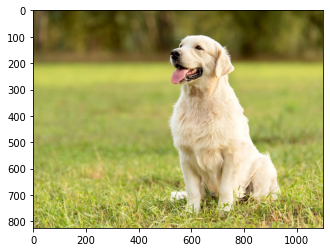

In [18]:
imagePath = './images/dog.jpg'
img = cv2.imread(imagePath)
image = cv2.resize(img, dsize=(px, px))
imageArr = image.reshape((1,px*px*3)).T
plt.imshow(mpimg.imread(imagePath))
print('cat' if prediction(imageArr,parameters) == 1 else 'Not a cat')